
# YIELD ESTIMATION MODEL 
The yield estimation was done in a greenhouse Tomato farm.<br>
using temperature data from the sensors that were installed in the farm<br>
The greenhouse has six blocks with a rotational crop calender through out the year<br>

## Using Different Model
To estimate the Yield based on cumulative growing degree

## Description of Data set
The farm is divided into Block(A,B,C,D,E,F)

In [1]:
import pandas as pd
import numpy as np
import pymysql
pymysql.install_as_MySQLdb()
import sys
import datetime as dt
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bkcharts import * 
from bokeh.models.widgets import Tabs, Panel
import pandas, datetime
from time import gmtime,strftime
from calendar import timegm
from bokeh.layouts import row, column, gridplot
from bokeh.models import Range1d
from bokeh.models import ColumnDataSource,HoverTool
from tabulate import tabulate

import statsmodels.formula.api as smf


In [2]:
# Connection to MySQL Database to get the data
conn = pymysql.connect(host = 'my DB IP', port= 3306, user ='user', passwd = 'my-password', db = 'DB_NAME')
cursor = conn.cursor()
cursor.execute('SELECT sdate,block,vid,A_harv,B_harv,loss FROM toguchi_harv order by sdate DESC')
result = cursor.fetchall()
df = pd.DataFrame( [[ij for ij in i] for i in result] )
df.rename(columns={0: 'date', 1: 'block', 2: 'vid', 3: 'A', 4: 'B', 5: 'Loss'}, inplace=True);
if cursor and conn:
    cursor.close()
    conn.close()

In [3]:
# Sum of A,B and Loss
df['Total'] = df[["A","B","Loss"]].apply(lambda row: np.sum(row),axis=1)

In [4]:
# Date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
#QUERY To select data BLOCKWISE
df_A = df.query('block == "A"')
df_B = df.query('block == "B"')
df_C = df.query('block == "C"')
df_D = df.query('block == "D"')
df_E = df.query('block == "E"')
df_F = df.query('block == "F"')

# QUERY to get Specific Varieties

df_A_v1 = df_A.query('vid == "v1"')
df_A_v2 = df_A.query('vid == "v2"')
df_A_v3 = df_A.query('vid == "v3"')


In [6]:
# Drop irrevant columns
df_Av1 = df_A_v1.drop(['block','vid','A','B','Loss'], 1)
df_Av2 = df_A_v2.drop(['block','vid','A','B','Loss'], 1)
df_Av3 = df_A_v3.drop(['block','vid','A','B','Loss'], 1)


In [7]:
# Sort the values , Without sorting, the date index are in increasing order and may not match in merging 
df_Av1 = df_Av1.sort_values(["date", "Total"])
df_Av2 = df_Av2.sort_values(["date", "Total"])
df_Av3 = df_Av3.sort_values(["date", "Total"])

In [8]:
df_Av1.head()

,date,Total
805,2016-05-04,2.0
804,2016-05-09,14.6
803,2016-05-11,21.7
802,2016-05-13,56.4
801,2016-05-16,79.6


## Import the Data with the Cumulative GDD (CGDD) 

In [9]:
dfA_GDD = pd.read_csv('dfA_GDD.csv')

dfA_GDD = dfA_GDD.drop(['Mean_T','GDD'], 1)
# Renaming the Data set column
new_names = ['date', 'Cum_GDD'] 
old_names = ['index', 'Cum_GDD'] 
dfA_GDD.rename(columns=dict(zip(old_names, new_names)), inplace=True)

dfA_GDD = dfA_GDD.set_index(['date'])

In [10]:
# the created indexed data
dfA_GDD.head()

,Cum_GDD
date,
2017-06-11,12.5
2017-06-12,25.8
2017-06-13,39.1
2017-06-14,53.9
2017-06-15,69.0


In [11]:
# Function to combine dataset
def combine_two_df(df1, df2):
    '''
    This will return the result of combined dataset 
    based on column of 'Date'.
    '''
    return df1.merge(df2, how='outer', left_index=True, right_index=True)

In [12]:
# Set index that is used in merging 
df_Av1 = df_Av1.set_index(['date'])
df_Av2 = df_Av2.set_index(['date'])
df_Av3 = df_Av3.set_index(['date'])

In [13]:
combined_dfv1 = combine_two_df(dfA_GDD,df_Av1)
combined_dfv2 = combine_two_df(dfA_GDD,df_Av2)
combined_dfv3 = combine_two_df(dfA_GDD,df_Av3)

In [14]:
# Function to Calculate the Cumulative Harvest
def full_df(df22):
    df22 = df22.reset_index(drop=False)
    df22['Cum_Yield'] = df22.Total.cumsum()
    df = df22
    return df

In [15]:
# CALCULATE Cumulative YIELD 
combined_df_cumYield_v1 = full_df(combined_dfv1)
combined_df_cumYield_v2 = full_df(combined_dfv2)
combined_df_cumYield_v3 = full_df(combined_dfv3)

In [16]:
# Drop irrevant data column
dfA_v1_GDD_clean11 = combined_df_cumYield_v1.drop('Total', 1)
dfA_v2_GDD_clean22 = combined_df_cumYield_v2.drop('Total', 1)
dfA_v3_GDD_clean33 = combined_df_cumYield_v3.drop('Total', 1)

In [17]:
dfA_v1_GDD_clean1 = dfA_v1_GDD_clean11.dropna()
dfA_v2_GDD_clean2 = dfA_v2_GDD_clean22.dropna()
dfA_v3_GDD_clean3 = dfA_v3_GDD_clean33.dropna()

In [18]:
dfA_v2_GDD_clean2.head()

,date,Cum_GDD,Cum_Yield
81,2017-06-19,129.6,370.9
83,2017-06-21,162.3,373.0
85,2017-06-23,196.7,383.6
88,2017-06-26,244.6,416.5
90,2017-06-28,279.6,430.6


# 1. Let us stat Linear Regression Using  statsmodels.model


## The data set used is:

In [19]:
dfA_v2_GDD_clean2.head()

,date,Cum_GDD,Cum_Yield
81,2017-06-19,129.6,370.9
83,2017-06-21,162.3,373.0
85,2017-06-23,196.7,383.6
88,2017-06-26,244.6,416.5
90,2017-06-28,279.6,430.6


In [20]:
dfA_v3_GDD_clean3.head()

,date,Cum_GDD,Cum_Yield
80,2017-06-19,129.6,322.8
82,2017-06-21,162.3,325.9
84,2017-06-23,196.7,339.5
87,2017-06-26,244.6,350.7
89,2017-06-28,279.6,353.8


## Using the Statsmodels.model
Using statsmodel.model Linear Regression analysis is done <br>
and the data is plotted using Bokeh

In [21]:
#df = dfA_GDD_clean
##################################################
########                              ############
#######          FOR V2 VARIETY      #############
#######                              #############
##################################################

# Assign Features and Target variable
y = dfA_v2_GDD_clean2['Cum_Yield'].values
x = dfA_v2_GDD_clean2['Cum_GDD'].values
xD = dfA_v2_GDD_clean2['date'].values

# Create the Model
lm = smf.ols(formula='Cum_Yield~Cum_GDD',data=dfA_v2_GDD_clean2)


lm_result = lm.fit()

print(lm_result.summary())
print(lm_result.params)

# Prediction on the data set
y_predictions = lm_result.predict()
y1 = y_predictions
#Outputs in Notebook


output_notebook()
#Output the Plot result as html that will be displayed in the browser
output_file("harvest_prediction.html", title="CGDD Vs Harvest Yield Regression of Greenhouse Block A")

p = figure(title="YIELD OF V2 Vs GDD",
           x_axis_label=" DATE",
           y_axis_label="Cum_Yield",
           x_axis_type='datetime',
           background_fill_color='#D1D1D8',
          # tools=[hover, 'xpan','reset','previewsave'],
           tools=['xpan', 'reset','previewsave'],
          # plot_width=1000,
           logo=None
          )

p.scatter(xD, y, legend="Actual Yield", marker="circle",color="red")

p.scatter(xD, y_predictions, legend="Predicted Yield", color="black")

p.line(xD, y_predictions, line_width=1,line_color="black")

p.line(xD, y, line_width=1,line_color="red")
#p.line(x, y, line_width=1, line_width=2)

p.legend.location = "top_left"

output_file("TOGUCHI_harvest_prediction.html")

#show(p)

##################################################
########                              ############
#######          FOR V3 VARIETY      #############
#######                              #############
##################################################

# Assign Features and Target variable
y3 = dfA_v3_GDD_clean3['Cum_Yield'].values
x3 = dfA_v3_GDD_clean3['Cum_GDD'].values
xD3 = dfA_v2_GDD_clean2['date'].values

# Create the Model
lm = smf.ols(formula='Cum_Yield~Cum_GDD',data=dfA_v3_GDD_clean3)
lm_result = lm.fit()
print(lm_result.summary())
print(lm_result.params)
# Prediction on the data set
y3_predictions = lm_result.predict()
y3 = y3_predictions

#Outputs in Notebook
output_notebook()

#output_file("housing_prices.html", title="LSTAT vs. Housing Prices Regression")
output_file("harvest_prediction.html", title="CGDD Vs Harvest Yield Regression of Greenhouse Block A")

p3 = figure(title="YIELD OF V3 Vs GDD",
           x_axis_label=" DATE",
            x_axis_type='datetime',
           y_axis_label="Cum_Yield",
           background_fill_color='#C7C5D0',
          # tools=[hover, 'xpan','reset','previewsave'],
           tools=['xpan', 'reset','previewsave'],
           #plot_width=1000,
           logo=None
          )

p3.scatter(xD3, y, legend="Actual Yield", marker="circle",color="red")

p3.scatter(xD3, y_predictions, legend="Predicted Yield", color="black")
p3.line(xD3, y_predictions, line_width=1,line_color="black")
p3.line(xD3, y, line_width=1,line_color="red")

p3.legend.location = "top_left"

show(row(p, p3))

                            OLS Regression Results                            
Dep. Variable:              Cum_Yield   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     811.0
Date:                Tue, 26 Sep 2017   Prob (F-statistic):           8.71e-16
Time:                        13:01:10   Log-Likelihood:                -70.206
No. Observations:                  19   AIC:                             144.4
Df Residuals:                      17   BIC:                             146.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    347.4899      5.373     64.668      0.0

/Users/denisrubanga/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


Loading BokehJS ...

                            OLS Regression Results                            
Dep. Variable:              Cum_Yield   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     625.6
Date:                Tue, 26 Sep 2017   Prob (F-statistic):           7.53e-15
Time:                        13:01:10   Log-Likelihood:                -59.574
No. Observations:                  19   AIC:                             123.1
Df Residuals:                      17   BIC:                             125.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    312.7697      3.162     98.909      0.0

Loading BokehJS ...

# 2. Using Train/Test Split
## The data is not that much but however, let us try some Machine Learning.
You will later realise that the data set is too small to give goog results 

R^2: 0.957233626191
Root Mean Squared Error: 8.42607841353
MODEL SCORE IS :0.957233626191
Score:  0.957233626191


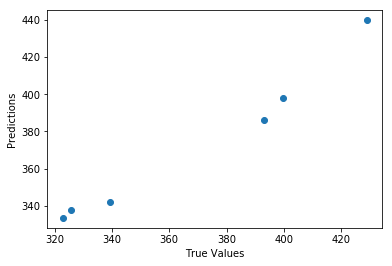

In [22]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline 

y = dfA_v3_GDD_clean3['Cum_Yield'].values
x = dfA_v3_GDD_clean3['Cum_GDD'].values
x4 = dfA_v3_GDD_clean3['date'].values

y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create training and test sets
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.5,random_state=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

# Create the regressor: reg_all
reg_all = linear_model.LinearRegression() 

# Fit the regressor to the training data to create a model
model = reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2: {}".format(reg_all.score(X_test, y_test)))
print("Root Mean Squared Error: {}".format(rmse))
print ("MODEL SCORE IS :{}" .format(reg_all.score(X_test, y_test)))
print "Score: " ,model.score(X_test,y_test)

#plt.scatter(y, y_pred)
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")



## From Above two Models
### Train/Test Split and Statsmodels.model
### Both have high R-Squared HOWEVER for such a small data set. ML is not appropriate

In [23]:
#y_test,y_pred

## Statsmodels on the train/Test split data

# 3. Cross validation

In [24]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from matplotlib import pyplot as plt
%matplotlib inline 
from beautifultable import BeautifulTable
table = BeautifulTable()

y = dfA_v3_GDD_clean3['Cum_Yield'].values
x = dfA_v3_GDD_clean3['Cum_GDD'].values

y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

df = dfA_v3_GDD_clean3
# Create a linear regression object: reg
#reg = LinearRegression()
reg = linear_model.LinearRegression() 

# Compute n-fold cross-validation scores: cv_scores
C = np.arange(2,9)
for c in C:
    print('FOR %.0f-FOLD : ' % c )
    # Make cross validated predictions
    Predictions = cross_val_predict(reg, x, y, cv=c)
    #print "Cross-validated prediction are:", Predictions
    cvscores_5 = cross_val_score(reg,x,y,cv=c)
    print('FOR %.0f-fold scores: ' % c )
    print(cvscores_5)
    print('The AVERAGE SCORE IS: ' )
    print("{}".format(np.max(cvscores_5)))
    
    
        

FOR 2-FOLD : 
FOR 2-fold scores: 
[ 0.33364129 -0.12058088]
The AVERAGE SCORE IS: 
0.333641294442
FOR 3-FOLD : 
FOR 3-fold scores: 
[ 0.0903894   0.57035744 -1.70271032]
The AVERAGE SCORE IS: 
0.570357436161
FOR 4-FOLD : 
FOR 4-fold scores: 
[  0.46610022   0.80292803   0.60428291 -54.09060611]
The AVERAGE SCORE IS: 
0.802928027767
FOR 5-FOLD : 
FOR 5-fold scores: 
[   0.20889532    0.68299154   -2.57212352    0.77360345 -121.02048183]
The AVERAGE SCORE IS: 
0.773603445778
FOR 6-FOLD : 
FOR 6-fold scores: 
[   0.20889532    0.37628521    0.46014849   -2.09624452    0.63305685
 -121.02048183]
The AVERAGE SCORE IS: 
0.633056852203
FOR 7-FOLD : 
FOR 7-fold scores: 
[ -1.54565525e+00   4.88963420e-02   7.29734403e-01  -6.16173274e+00
   7.97567843e-01  -2.12022230e+01  -7.09624441e+02]
The AVERAGE SCORE IS: 
0.797567843386
FOR 8-FOLD : 
FOR 8-fold scores: 
[ -1.54565525e+00   4.88963420e-02   7.29734403e-01  -2.65371445e+01
  -1.16546832e+00   6.73067142e-01  -2.12022230e+01  -7.09624441e+

/Users/denisrubanga/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


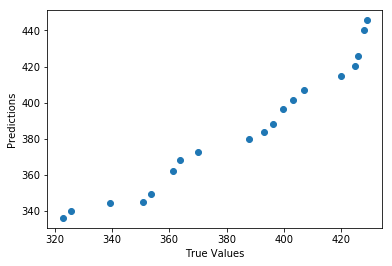

In [25]:
plt.scatter(y, Predictions)
#plt.scatter(y_test, Predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")